In [2]:
using Revise

using LinearAlgebra, QuadGK, Roots, FFTW, FastGaussQuadrature, SpecialFunctions
using Triangulate
using VlasovSolvers
import VlasovSolvers: advection!
import VlasovSolvers: samples, Particles, PF_step!, ParticleMover, kernel_poisson!, kernel_gyrokinetic!

using ProgressMeter, Printf
using Plots, LaTeXStrings

# Quadrature rules

In [3]:
struct RectangleRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Vector{Float64}
    weights :: Vector{Float64}
    step :: Float64

    function RectangleRule(len, start, stop)
        points = LinRange(start, stop, len+1)[1:end-1]
        s = step(points) 
        weights = [s for _ = 1:len]
        new(len, start, stop, vec(points), weights, s)
    end
end

In [4]:
struct TrapezoidalRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Vector{Float64}
    weights :: Vector{Float64}
    step :: Float64

    function TrapezoidalRule(len, start, stop)
        points = LinRange(start, stop, len)[1:end]
        s = step(points) 
        weights = [s for _ = 1:len]
        weights[1] /= 2
        weights[end] /= 2
        new(len, start, stop, vec(points), weights, s)
    end
end

In [5]:
struct SimpsonRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Vector{Float64}
    weights :: Vector{Float64}
    step :: Float64

    function SimpsonRule(len, start, stop)
        # make sure the number of points is uneven
        if len % 2 == 0
            len += 1
        end
        points = LinRange(start, stop, len)
        s = step(points) 
        weights = s/3 .* ones(len)
        weights[2:2:end-1] .*= 4
        weights[3:2:end-2] .*= 2
        new(len, start, stop, vec(points), weights, s)
    end
end

In [6]:
struct GaussHermiteRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Array{Float64}
    weights :: Array{Float64}

    function GaussHermiteRule(len, start, stop)
        points, weights = gausshermite(len)
        weights .*= exp.(points.^2)
        new(len, start, stop, points, weights)
    end
end

In [7]:
struct GaussLegendreRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Array{Float64}
    weights :: Array{Float64}

    function GaussLegendreRule(len, start, stop)
        points, weights = gausslegendre(len)
        points .+= 1
        points .*= (stop - start) / 2
        points .+= start
        weights .*= (stop - start) / 2
        new(len, start, stop, points, weights)
    end
end

In [8]:
struct GaussRadauRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Array{Float64}
    weights :: Array{Float64}

    function GaussRadauRule(len, start, stop)
        points, weights = gaussradau(len)
        points .+= 1
        points .*= (stop - start) / 2
        points .+= start
        weights .*= (stop - start) / 2
        new(len, start, stop, points, weights)
    end
end

In [9]:
struct GaussLobattoRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Array{Float64}
    weights :: Array{Float64}

    function GaussLobattoRule(len, start, stop)
        points, weights = gausslobatto(len)
        points .+= 1
        points .*= (stop - start) / 2
        points .+= start
        weights .*= (stop - start) / 2
        new(len, start, stop, points, weights)
    end
end

In [10]:
struct KronrodRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Vector{Float64}
    weights :: Vector{Float64}
    step :: Float64

    function KronrodRule(len, start, stop)
        pts, w, _ = kronrod(len)
        weights = []
        points = []
        for i = 1:len
            push!(points, pts[i])
            push!(weights, w[i])
            push!(points, -pts[i])
            push!(weights, w[i])
        end
        push!(points, pts[end])
        push!(weights, w[end])
        
        points .+= 1
        points .*= (stop - start) / 2
        points .+= start
        weights .*= (stop - start) / 2
        len = 2*len + 1
        new(len, start, stop, points, weights)
end
    end

In [11]:
# Only works for rectangle and trapezoidal rules
function projection_onto_grid!(grid_dst, meshx, meshv, X, V_, W)
    meshxstep = meshx[2] - meshx[1]
    meshvstep = meshv[2] - meshv[1]
    grid_dst .= 0


    # Periodic Boundary conditions on velocity
    V = copy(V_)
    V[findall(v -> v >= meshv[end],  V)] .-= meshv[end] - meshv[1]
    V[findall(v -> v < meshv[1],  V)] .+= meshv[end] - meshv[1]
    
    for ipart = 1:length(X)
        idxgridx = Int64(fld(X[ipart],            meshxstep)) + 1
        idxgridv = Int64(fld(V[ipart] - meshv[1], meshvstep)) + 1
        idxgridxp1 = idxgridx<length(meshx) ? idxgridx+1 : 1
        idxgridvp1 = idxgridv<length(meshv) ? idxgridv+1 : 1
        
        tx = (X[ipart]             - (idxgridx-1) * meshxstep) / meshxstep
        tv = (V[ipart] - meshv[1]  - (idxgridv-1) * meshvstep) / meshvstep

        # println((idxgridv, V[ipart]))
        grid_dst[idxgridx  , idxgridv  ] += W[ipart] * (1-tx) * (1-tv)
        grid_dst[idxgridx  , idxgridvp1] += W[ipart] * (1-tx) * tv
        grid_dst[idxgridxp1, idxgridvp1] += W[ipart] * tx     * tv
        grid_dst[idxgridxp1, idxgridv  ] += W[ipart] * tx     * (1 - tv)
    end
end

projection_onto_grid! (generic function with 1 method)

# Numerical examples

In [12]:
struct LandauDamping
    α
    kx
    μ
    β
    f0
    shortname
    longname
    L 
    vmin 
    vmax

    function LandauDamping(alpha, kx, mu, beta; 
                            shortname="Landau", longname="(Strong/Weak) Landau damping", L=nothing, vmin=-9, vmax=9)
        isnothing(L) ? L = 2π / kx : nothing
        f(x,v) = (1 + alpha * cos(kx*x)) * exp(- beta * (v-mu)^2 / 2) / √(2π/beta)
        new(alpha, kx, mu, beta, f, shortname, longname, L, vmin, vmax)
    end
end

struct TwoStreamInstability 
    α
    kx
    β
    f0
    shortname
    longname
    L 
    vmin 
    vmax
    v0

    function TwoStreamInstability(alpha, kx, v0; 
                                    shortname="TSI", longname="Two-Stream Instability", L=nothing, vmin=-9, vmax=9)
        isnothing(L) ? L = 2π / kx : nothing
        f(x,v) = (1 + alpha * cos(kx*x)) * (exp(- (v-v0)^2 / 2) + exp(- (v+v0)^2 / 2)) / (2*√(2π))
        new(alpha, kx, 1., f, shortname, longname, L, vmin, vmax, v0)
    end
end

struct TwoStreamInstabilityAlternativeFormulation
    α
    kx
    β
    f0
    shortname
    longname
    L 
    vmin 
    vmax

    function TwoStreamInstabilityAlternativeFormulation(alpha, kx; 
                                    shortname="TSI_alt", longname="Two-Stream Instability Alternative Formulation", L=nothing, vmin=-9, vmax=9)
        isnothing(L) ? L = 2π / kx : nothing
        f(x,v) = (1 - alpha * cos(kx*x)) * exp(- v^2 / 2) * v^2 / √(2π)
        new(alpha, kx, 1., f, shortname, longname, L, vmin, vmax)
    end
end

struct BumpOnTail 
    α
    kx
    μ₁
    μ₂
    β₁
    β₂
    n₁
    n₂
    f0
    shortname
    longname
    L 
    vmin 
    vmax

    function BumpOnTail(alpha, kx, mu1, mu2, beta1, beta2; 
                        n1=0.9, n2=0.2, shortname="BoT", longname="Bump on Tail", L=nothing, vmin=-9, vmax=9)
        isnothing(L) ? L = 2π / kx : nothing
        f(x,v) = (1 + alpha * cos(kx*x)) * ((n1*exp(-beta1*(v-mu1)^2 /2) + n2*exp(-beta2*(v-mu2)^2 / 2)) / √(2π))
        new(alpha, kx, mu1, mu2, beta1, beta2, n1, n2, f, shortname, longname, L, vmin, vmax)
    end
end

struct NonHomogeneousStationarySolution
    α
    kx
    β
    M₀
    f0
    shortname
    longname
    L
    vmin
    vmax

    function getM₀(α, β)
        find_zero( (M) -> M - α * √(2π/β) * besseli(1, M * β) * 2, 10)
        # 2 factor because of the definition of I₁(z) and C(t):
        # I₁(z) = 1/π ∫_0^π exp(z cos(θ)) cos(θ) dθ
        #       = 1/(2π) ∫_0^{2π} exp(z cos(θ)) cos(θ) dθ
        # C(t)  = 1/π ∫_0^{2π} ∫_{-∞}^{+∞} f(t,θ,v) cos(θ) dθ dv
        #       = 2α √(2π/β) I₁(βM₀)
    end

    function NonHomogeneousStationarySolution(alpha, kx, beta;
                                                shortname="non-homog", longname="Non Homogeneous Stationary Solution", L=nothing, 
                                                vmin=-9, vmax=9)
        isnothing(L) ? L = 2π / kx : nothing
        m = getM₀(alpha, beta)
        new(alpha, kx, beta, m, (x,v) -> alpha * exp.(-beta * (v^2 / 2 - m * cos(x*kx))), shortname, longname, L, vmin, vmax)
    end
end

struct StationaryGaussian
    α
    kx
    β
    f0
    shortname
    longname
    L
    vmin
    vmax

    function StationaryGaussian(alpha, kx, beta;
                                                shortname="gaussian", longname="Stationary Gaussian", L=nothing, 
                                                vmin=-9, vmax=9)
        isnothing(L) ? L = 2π / kx : nothing
        new(alpha, kx, beta, (x,v) -> alpha * exp.(-beta * v^2 / 2) / √(2π/beta), shortname, longname, L, vmin, vmax)
    end
end

struct Test
    α
    kx
    β
    f0
    shortname
    longname
    L
    vmin
    vmax

    function Test(alpha, kx, beta;
                                shortname="test", longname="Test", L=nothing, 
                                vmin=-9, vmax=9)
        isnothing(L) ? L = 2π / kx : nothing
        new(alpha, kx, beta, (x,v) -> alpha * exp.(-beta * (v - (vmin+vmax)/2)^2 / 2) / √(2π/beta) * exp.(-beta * (x - L/2)^2 / 2) / √(2π/beta), shortname, longname, L, vmin, vmax)
    end
end

example_landaudamping = LandauDamping(0.001, 0.5, 0., 1.; 
                                        longname="Weak Landau damping", shortname="weakLD", vmin=-9, vmax=9);
example_stronglandaudamping = LandauDamping(0.5, 0.5, 0., 1.; longname="Strong Landau damping", shortname="strongLD");
example_twostreaminstability = TwoStreamInstability(0.001, 0.2, 3.);
example_twostreaminstabilityalternativeformulation = TwoStreamInstabilityAlternativeFormulation(0.05, 0.2);
example_bumpontail = BumpOnTail(0.04, 0.3, 0, 4.5, 1, 4);
example_nonhomogeneousstationarysolution = NonHomogeneousStationarySolution(0.2, 1, 2);
example_stationarygaussian = StationaryGaussian(0.2, 1, 1);
example_test = Test(0.2, 1, 1);

# SL classique

In [13]:
"""
    hmf_poisson!(fᵗ    :: Array{Complex{Float64},2},
                 mesh1 :: OneDGrid,
                 mesh2 :: OneDGrid,
                 ex    :: Array{Float64})

    Compute the electric hamiltonian mean field from the
    transposed distribution function

"""
function hmf_poisson!(fᵗ::Array{Complex{Float64},2},
        mesh1::OneDGrid,
        mesh2::OneDGrid,
        ex::Array{Float64}; K=1)

    n1 = mesh1.len
    rho = mesh2.step .* vec(sum(fᵗ, dims=1)) # ≈ ∫ f(t,x_i,v)dv, i=1, ..., n1
    kernel = zeros(Float64, n1)
    ker = -(mesh1.stop - mesh1.start) / (2π)
    for k=1:K
        kernel[1+k]   =  ker / k    # fourier mode  1
        kernel[end - (k-1)] = -ker / k    # fourier mode -1
    end
    ex .= real(ifft(fft(rho) .* 1im .* kernel))
end

function solve_SL!(nsteps, dt, f, mesh1, mesh2, kx; plotting=false::Bool)
    n1, n2 = size(f)
    fᵗ = zeros(Complex{Float64}, (n2,n1))
    transpose!(fᵗ, f)

    results = (Eelec = Array{Float64}(undef, nsteps),
                Etot = Array{Float64}(undef, nsteps),
                momentum = Array{Float64}(undef, nsteps),
                L²norm = Array{Float64}(undef, nsteps))


    ex = zeros(Float64, n1)
    hmf_poisson!(fᵗ, mesh1, mesh2, ex)
    advection!(fᵗ, mesh2, ex, 0.5dt)

    progression = ProgressMeter.Progress(nsteps,desc="Loop in time: ", showspeed=true)
    
    animation = @animate for istep = 1:nsteps
        results.Eelec[istep] = sum(ex.^2) * mesh1.step
        results.Etot[istep] = (results.Eelec[istep] + sum(mesh2.points'.^2 .* real(f)) * mesh1.step * mesh2.step) / 2
        results.momentum[istep] = sum(sum(real(f), dims=1) .* mesh2.points) * mesh1.step * mesh2.step
        results.L²norm[istep] = sum(real(f).^2) * mesh1.step * mesh2.step
    
        advection!(f, mesh1, mesh2.points, dt)
        transpose!(fᵗ, f)
        hmf_poisson!(fᵗ, mesh1, mesh2, ex)
        advection!(fᵗ, mesh2, ex, dt)
        transpose!(f, fᵗ) 
        
        if plotting
            plot(mesh1.points, mesh2.points, real(f)', size=(500, 500), st=:surface, camera=(0, 90))
            title!("Progression: $(round(Int64,100*progression.counter / progression.n))%")
        end
        
        ProgressMeter.next!(progression)
    end when plotting
    if !plotting
        animation = nothing
    end
    
    results.Eelec .= sqrt.(results.Eelec)
    results.Etot .= sqrt.(results.Etot)
    results.L²norm .= sqrt.(results.L²norm)
    
    return results, animation
end

solve_SL! (generic function with 1 method)

# PIC solver

In [14]:
function solve_PF!(nsteps, dt, particles, meshx, example, weights; plotting=false::Bool, kernel=kernel_poisson!, T=NaN)
    init_pos = copy(particles.x)
    init_vel = copy(particles.v)

    np = particles.nbpart

    results = (Eelec = Array{Float64}(undef, nsteps),
                Etot = Array{Float64}(undef, nsteps),
                momentum = Array{Float64}(undef, nsteps),
                L²norm = Array{Float64}(undef, nsteps),
                C = Array{Float64}(undef, nsteps),
                S = Array{Float64}(undef, nsteps),
                historyX = Array{Float64}(undef, np, nsteps+1),
                historyV = Array{Float64}(undef, np, nsteps+1))

    pmover = ParticleMover(particles, meshx, 1, dt; example.kx)

    results.historyX[:, 1] .= particles.x
    results.historyV[:, 1] .= particles.v

    if plotting
        widthx = -(-)(extrema(quadrulex.points)...)
        widthv = -(-)(extrema(quadrulev.points)...)
        scale = 0.9
    end
    
    progression = ProgressMeter.Progress(nsteps, desc="Loop in time: ", showspeed=true)
    animation = @animate for istep = 1:nsteps
        
        results.Eelec[istep], results.momentum[istep], results.Etot[istep] = PF_step!(particles, pmover; kernel=kernel)
        results.C[istep] = pmover.C[1]
        results.S[istep] = pmover.S[1]
        results.L²norm[istep] = sum(particles.wei.^2 ./ vec(weights))
        results.historyX[:, istep+1] .= particles.x
        results.historyV[:, istep+1] .= particles.v
        
        if istep % T == 0
            # p.wei .= nufft_interpolation(p.wei, p.x, p.v, init_pos, init_vel) .* weights
            particles.wei .= triangulation_interpolation(particles.wei ./ vec(weights), particles.x, particles.v, 
                                                            init_pos, init_vel, example)[1]
            particles.wei .*= vec(weights)
            particles.x .= init_pos
            particles.v .= init_vel
        end
        
        if plotting
            plot(particles.x, particles.v, seriestype=:scatter, zcolor=vec(particles.wei), 
                markersize=sqrt(600*600 / (nx*nv) / π) * scale, zticks=[], camera=(0, 90), 
                markerstrokecolor="white", markerstrokewidth=0, label="", c=:jet1,
                aspect_ratio=:equal, size=(600, 600), 
                title="t = $(@sprintf("%.3f",istep*dt))\nProgression: $(round(Int64,100*progression.counter / progression.n))%", titlefontsize=8, margin=5Plots.mm)
        end

        ProgressMeter.next!(progression)
    end when plotting
    if !plotting
        animation = nothing
    end
    
    results.Eelec .= sqrt.(results.Eelec)
    results.Etot .= sqrt.(results.Etot)
    results.L²norm .= sqrt.(results.L²norm)
    
    return results, animation
end

solve_PF! (generic function with 1 method)

In [15]:
function triangulation_interpolation(_valsf, _pos, _vel, gridxoutput, gridvoutput, example; 
                                        returntriangulation=false)
"""
Perform a linear interpolation of the data to the grid by using a Delaunay triangulation.

    Steps:
    1. Create the Delaunay triangulation
    2. For each point (x,v) in (gridxoutput, gridvoutput)
        a. Get the triangle T in which (x,v) lies, by iterating over all the triangles and testing each one of them
        b. From the vertices of T get a linear interpolation of the function at x, using barycentric coordinates
    """
    
    myoutput = similar(gridxoutput)

    pointset = Triangulate.TriangulateIO()

    @views pointset.pointlist = vcat(_pos', _vel')
    pointset.pointattributelist = _valsf'
    (triangulation, _) = Triangulate.triangulate("Q", pointset);

    indicestoreview = []

    # Interpolate using the triangulation
    @views @inbounds for part=eachindex(gridxoutput)
        myoutput[part] = triangleContainingPoint(triangulation, gridxoutput[part], gridvoutput[part])[1]
        myoutput[part] < 0 ? push!(indicestoreview, part) : nothing
    end

    # Perform rough approximation when the triangulation could not help us interpolate.
    # In this case we suppose the function is constant between the closest known value at the same velocity and the 
    # point at the desired location. 
    @views @inbounds for part=indicestoreview
        xline = findall((gridvoutput .== gridvoutput[part]).&&(myoutput .≥ 0)) 
        myoutput[part] = 0.0 # set value to 0.0 if nothing better can be done
        if isempty(xline)
            continue
        end
        x = gridxoutput[part]
        idxxminknown = minimum(xline)
        xminknown = gridxoutput[idxxminknown]
        idxxmaxknown = maximum(xline)
        xmaxknown = gridxoutput[idxxmaxknown]
        x > xmaxknown ? x -= example.L : nothing
        myoutput[part] = myoutput[idxxminknown] * (x-xmaxknown+example.L) / (xminknown - xmaxknown + example.L) +
                    myoutput[idxxmaxknown] * (1 - (x-xmaxknown+example.L) / (xminknown - xmaxknown + example.L))
    end 

    returntriangulation ? nothing : triangulation=nothing
    return vec(myoutput), triangulation
end


function triangleContainingPoint(triangulation, x, v)
    @views @inbounds for (idxA, idxB, idxC) = eachcol(triangulation.trianglelist)
        
        A = triangulation.pointlist[:, idxA]
        B = triangulation.pointlist[:, idxB]
        C = triangulation.pointlist[:, idxC]
        
        # if x is outside of the rectangle defined by [minX(A, B, C), maxX(A, B, C)],
        # or v is outside of the rectangle defined by [minV(A, B, C), maxV(A, B, C)],
        # then we don't have to do the computations
        if      ((x < A[1]) && (x < B[1]) && (x < C[1])) || ((x > A[1]) && (x > B[1]) && (x > C[1]))
            continue
        elseif  ((v < A[2]) && (v < B[2]) && (v < C[2])) || ((v > A[2]) && (v > B[2]) && (v > C[2]))
            continue
        end
        
        # Use barycentric coordinates:
        det = (A[1] - C[1])*(B[2] - C[2]) - (A[2] - C[2])*(B[1] - C[1])
        λ₁ = (x - C[1])*(B[2] - C[2]) + (v - C[2])*(C[1] - B[1])
        λ₂ = (x - C[1])*(C[2] - A[2]) + (v - C[2])*(A[1] - C[1])
        λ₁ /= det 
        λ₂ /= det
        
        if (λ₁≥0)&&(λ₂≥0)&&(λ₁+λ₂≤1)
            wA = triangulation.pointattributelist[1, idxA]
            wB = triangulation.pointattributelist[1, idxB]
            wC = triangulation.pointattributelist[1, idxC]
            return wA * λ₁ + wB * λ₂ + (1 - λ₁ - λ₂) * wC, (idxA, idxB, idxC)
        end
    end

    return -1., (-1, -1, -1)
end

triangleContainingPoint (generic function with 1 method)

# Inputs

In [107]:
dev = CPU()

imgdir = "../../../latex/imgs/png/triangulation/" # Folder in which to store images 


# example = example_landaudamping
example = example_stronglandaudamping
# example = example_twostreaminstability
# example = example_twostreaminstabilityalternativeformulation
# example = example_bumpontail
# example = example_stationarygaussian
# example = example_nonhomogeneousstationarysolution
# example = example_test

nstep =150
dt = 0.1

nxsl = 128
nvsl = 129
meshx = OneDGrid(dev, nxsl, 0, example.L);
meshv = OneDGrid(dev, nvsl, example.vmin, example.vmax);

quadX = RectangleRule
quadV = RectangleRule
nxpf = 128
nvpf = 129
quadrulex = quadX(nxpf, 0, example.L);
quadrulev = quadV(nvpf, example.vmin, example.vmax);
# # quadrulev = quadV(nv, μ - 5/√β, μ + 5/√β)
# quadrulev = quadV(nv, example.μ - 5/√example.β, example.μ + 5/√example.β)

In [108]:
# kx = example.kx
# β = example.β
# α = example.α
# M₀ = example.M₀

# println("M₀ = $(M₀)")

# rule = RectangleRule(nx, 0, example.L);
# println("Rectangles:\t$(sum(cos.(kx.*rule.points) .* rule.weights))")
# rule = TrapezoidalRule(nx, 0, example.L);
# println("Trapèzes:\t$(sum(cos.(kx.*rule.points) .* rule.weights))")
# rule = GaussLegendreRule(nx, 0, example.L);
# println("Gauss-Legendre:\t$(sum(cos.(kx.*rule.points) .* rule.weights))")

# println(repeat("=", 45))

# println("π M₀ = \t\t"     *   "$(π * M₀)")
# rule = RectangleRule(nx, 0, example.L);
# println("Rectangles:\t"   *   "$(sum(cos.(rule.points) .* example.f0.(rule.points, quadrulev.points') .* rule.weights.*quadrulev.weights'))")
# rule = TrapezoidalRule(nx, 0, example.L);
# println("Trapèzes:\t"     *   "$(sum(cos.(rule.points) .* example.f0.(rule.points, quadrulev.points') .* rule.weights.*quadrulev.weights'))")
# rule = GaussLegendreRule(nx, 0, example.L);
# println("Gauss-Legendre:\t" * "$(sum(cos.(rule.points) .* example.f0.(rule.points, quadrulev.points') .* rule.weights.*quadrulev.weights'))")

In [109]:
# besseli(1, β * M₀) * α * √(2π/β) * 2 - M₀

In [110]:
# gridv = example.vmin:0.01:example.vmax

# ex_quadrulev = quadV(nv, example.vmin, example.vmax);
# ex_quadrulev2 = quadV(nv, example.μ - 5/√example.β, example.μ + 5/√example.β)
# ex_quadrulev3 = quadV(nv, example.μ - 4/√example.β, example.μ + 4/√example.β)

# plot(gridv, example.f0.(π/2, gridv))
# plot!(ex_quadrulev.points, zeros(ex_quadrulev.len) .+ 0.01, seriestype=:scatter, markerstrokewidth=0, label="grille totale")
# plot!(ex_quadrulev2.points, zeros(ex_quadrulev2.len) .+ 0.025, seriestype=:scatter, markerstrokewidth=0, label="±5σ")
# plot!(ex_quadrulev3.points, zeros(ex_quadrulev3.len) .+ 0.040, seriestype=:scatter, markerstrokewidth=0, label="±4σ")

In [111]:
# plot(quadrulex.points, quadrulev.points, vec(example.f0.(quadrulex.points, quadrulev.points')), c=:jet1, st=:surface)
# xlabel!("x")
# ylabel!("v")
# # savefig("gif/gyrokinetic_example.png")

# Simulations

In [112]:
gsl = zeros(Complex{Float64}, (nxsl, nvsl));
@. gsl = example.f0.(meshx.points, meshv.points');
@time resSL, animSL = solve_SL!(nstep, dt, gsl, meshx, meshv, example.kx; plotting=false);

Loop in time: 100%|███████████████████████| Time: 0:00:01 ( 8.58 ms/it)


  1.292898 seconds (2.82 M allocations: 289.333 MiB, 4.40% gc time)


In [113]:
if animSL != nothing
    gif(animSL, "gif/tmp.mp4");
end

# PIC interpretation

In [114]:
T = NaN

nbparticles = nxpf*nvpf
x0_init = copy(vec(repeat(quadrulex.points, 1, nvpf)))
v0_init = copy(vec(repeat(quadrulev.points', nxpf, 1)))
x0 = copy(vec(repeat(quadrulex.points, 1, nvpf)))
v0 = copy(vec(repeat(quadrulev.points', nxpf, 1)))
weights = quadrulex.weights .* quadrulev.weights'
wei = vec(example.f0.(quadrulex.points, quadrulev.points') .* weights)
particles = Particles(x0, v0, wei, nbparticles);
@time resPF, animPF = solve_PF!(nstep, dt, particles, meshx, example, vec(weights) ; 
                                    plotting=false, kernel=kernel_poisson!, T=T);

Loop in time: 100%|███████████████████████| Time: 0:00:00 ( 2.90 ms/it)


  0.436580 seconds (72.03 k allocations: 273.005 MiB, 13.52% gc time)


In [79]:
if animPF != nothing
    # gif(animPF, "gif/nonstationary_remapping_T$(@sprintf("%03d", T)).mp4");
    gif(animPF, "gif/tmp.mp4");
end

## Plot particles

In [ ]:
plot(vec(particles.x), vec(particles.v), seriestype=:scatter, markersize=sqrt(600*600 / (nxsl*nvsl) / π) * 0.5, camera=(0, 90), markerstrokecolor="white", markerstrokewidth=0, label="", zcolor=vec(particles.wei), c=:jet1, aspect_ratio=:equal, size=(600, 600), right_margin=5Plots.mm)

## Triangulation interpolation

In [ ]:
function plot_triangulation(tri; p=nothing, scaled=false)
    if p==nothing 
        p = plot()
    end

    @views begin
        x1 = tri.pointlist[1, tri.trianglelist'[:, 1]]'
        x2 = tri.pointlist[1, tri.trianglelist'[:, 2]]'
        x3 = tri.pointlist[1, tri.trianglelist'[:, 3]]'
        posX = vec(vcat(x1, x2, x3, x1, NaN*similar(x1)))
        v1 = tri.pointlist[2, tri.trianglelist'[:, 1]]'
        v2 = tri.pointlist[2, tri.trianglelist'[:, 2]]'
        v3 = tri.pointlist[2, tri.trianglelist'[:, 3]]'
        posV = vec(vcat(v1, v2, v3, v1, NaN*similar(v1)))
    end
    if scaled 
        posX .-= 1; posX .*= example.L
        posV .-= 1; posV .*= example.vmax - example.vmin; posV .+= example.vmin;
    end
    plot!(p, posX, posV, c=:rainbow, label="Delaunay Triangulation", linewidth=0.1)
    return p
end

In [ ]:
(newf, triangulation) = triangulation_interpolation(particles.wei ./ vec(weights), particles.x, particles.v, x0_init, v0_init, example; returntriangulation=true)
newf .*= vec(weights);

In [ ]:
p1 = plot(particles.x, particles.v, seriestype=:scatter, 
        markersize=sqrt(600*600 / (nxpf*nvpf) / π) * 0.4, camera=(0, 90), 
        markerstrokecolor="white", markerstrokewidth=0, label="Particules", zcolor=newf,
        title=example.shortname * "\n($(quadX)($(nxpf)), $(quadV)($(nvpf)))", titlefontsize=8, c=:jet1)
# p1 = plot(x0_init, v0_init, seriestype=:scatter, 
#         markersize=sqrt(600*600 / (nx*nv) / π) * 0.3, camera=(0, 90), 
#         markerstrokecolor="white", markerstrokewidth=0, label="Particules", zcolor=newf,
#         title=example.shortname * "\n($(quadX)($(nx)), $(quadV)($(nv)))", titlefontsize=8, c=:jet1)
plot_triangulation(triangulation; p=p1)
# p2 = plot(x0_init, v0_init, newf, st=:surface, camera=(0, 90), title="Interpolated", titlefontsize=8, c=:jet1)
# p2 = plot(quadrulex.points, quadrulev.points, reshape(newf, nx, nv)', st=:contour, title="Interpolated", titlefontsize=8, c=:jet1, levels=25)
# plot(p1, p2, size=(1200, 600))
plot(p1)
# plot(p2)

### Successive interpolations

In [ ]:
newf = copy(particles.wei) ./ vec(weights)
newx = copy(particles.x)
newv = copy(particles.v)

myplots = []

push!(myplots, plot(particles.x, particles.v, seriestype=:scatter, markersize=1, camera=(0, 90), markerstrokecolor="white", markerstrokewidth=0, label="", zcolor=particles.wei, c=:jet1, zticks=[], colorbar=false, titlefontsize=8))
title!(example.shortname * "\n($quadX($nxpf), $quadV($nvpf)),\nafter time $(nstep*dt)", titlefontsize=8)

tokeep = [1, 2, 5, 10, 20]
@showprogress for i = 1:maximum(tokeep)
    (newf, triangulation) = triangulation_interpolation(newf, newx, newv, x0_init, v0_init, example; returntriangulation=true)
    (i ∈ tokeep) && (push!(myplots, plot(x0_init, v0_init, newf .* vec(weights), st=:surface, camera=(0, 90), title="Interpolated $i times", titlefontsize=8, c=:jet1, zcolor=particles.wei, colorbar=false, zticks=[],
    margin=10Plots.mm)))
    # we now know `newf` at x0_init, v0_init so we update newx, newv
    newx = copy(x0_init) .+ rand() * (quadrulex.points[2] - quadrulex.points[1]) * 0.5
    newv = copy(v0_init) .+ rand() * (quadrulev.points[2] - quadrulev.points[1]) * 0.5
end

In [ ]:
cbar = scatter([0,0], [0,1], zcolor=particles.wei,
                xlims=(1,1.1), xshowaxis=false, xticks=[],
                yshowaxis=false, yticks=[],
                label="", c=:jet1, grid=false, 
                left_margin=25Plots.mm, right_margin=3Plots.mm)

l = @layout [
    [grid(2,3)] a{0.01w}
]
plot(myplots..., cbar, layout=l, size=(1000, 600))

In [ ]:
savefig(imgdir * "$(example.shortname)_successive_interpolations_afterfixing_periodic.png")

# Classical PIC

In [ ]:
# nbparticlespic = Int64(2e5)
# (x0, y0, wei) = samples(np, example.kx, example.α, example.μ, example.β)
# p = Particles(x0, y0, wei, nbparticlespic);
# @time E_elecpic, momentumpic, E_totpic, animation = solve_PIC!(nstep, dt, p, meshx;plotting=false, kx=example.kx);

# Plots

In [ ]:
t = (1:nstep) .* dt


plot(legend=:bottomright, minorgrid=true, size=(600, 400))

# energies
# plot!(t .+ dt,   resPF.Eelec, label=L"\log_{10}(E_{elec, PF}),\quad dt="*"$(dt)")
# plot!(t .- dt/2, resSL.Eelec, label=L"\log_{10}(E_{elec, SL}),\quad dt="*"$(dt)", ls=:dash, lw=1)

# log(Energies)
plot!(t .+ dt,   log10.(resPF.Eelec), label=L"\log_{10}(E_{elec, PF}),\quad dt="*"$(dt)")
plot!(t .- dt/2, log10.(resSL.Eelec), label=L"\log_{10}(E_{elec, SL}),\quad dt="*"$(dt)", ls=:dash, lw=1)
# plot!(t, log.(E_tot),       label=L"\log(E_{tot}),\quad dt="*"$(dt)")
# plot!(t, log.(E_elecpic), label=L"$\log(E_{elec, PIC}),\quad$ dt="*"$(dt), "* L"$n_p$ ="*"$(nbparticlespic)", ls=:dot)
# plot!(t, log.(energy_from_projection), label=L"\log(E_{pic, PIC}),\quad dt="*"$(dt)")
# plot!(t, log.(energy_elec_from_phi), label=L"\log(E_{from\,\Phi, PIC}),\quad dt="*"$(dt)")


# ============== #

# Landau damping (kx=0.5):
# plot!(x->-0.1533x - 5.6, label="Damping attendu (-0.1533)")
# E_th = abs.(4ϵ * 0.3677 .* exp.(−0.1533 .* t) .* cos.(1.4156.*t .−0.5326245)) * sqrt(L/2)
# plot!(t, log.(E_th),label="Energie theorique")
# Landau damping (kx=0.4):
# plot!(x->-0.0661x - 5.3, label="Damping attendu (-0.0661)")
# E_th = 0.002.*0.42466.*abs.(cos.(1.285.*t .-0.33577)).*exp.(-0.0661.*t) # expression du bouquin, pas correcte
# E_th = abs.(4*ϵ*0.424666*exp.(-0.0661 .* t) .* cos.(1.2850 .* t .- 0.3357725) * sqrt(L/2)) # issue des calculs du bouquin en calculant correctement √(∫sin(0.5x)^2dx)
# plot!(t, log.(E_th),label="Energie theorique", ls=:dashdotdot)

# TSI (k,v0) = (0.2, 1.3):
# plot!(t, -0.001t .- 4.2, label=L"y=0.001t - 5.0")
# TSI (k,v0) = (0.2, 2.4):
# plot!(t, 0.2258t .- 6.4, label=L"y=0.2258t - 8.4")
# TSI (k,v0) = (0.2, 3):
# plot!(t, 0.2845t .- 6.2, label=L"y=0.2845t - 8.2")

# Strong Landau damping
# plot!(t, -0.285473t .+ 1, label=L"y=-0.285473t + 1")
# plot!(t, 0.086671t .- 3.7, label=L"y=0.086671t - 3.7")

title!(example.longname * "\n($(quadX)($(nxpf)), $(quadV)($(nvpf)))", titlefontsize=8)
xlabel!("t (T=$(T))")
# xlabel!("time")

In [ ]:
savefig(imgdir*"/tmp.png")

# Plot annotations

In [ ]:
period = 2π / 1.4156
vline!(vcat([4 + i*period for i=0:4], [49.5 + i*period for i=0:3]), label="")
# vline!([28.1 + i*p for i=-4:0], label="")

In [ ]:
plot!([49.5, 49.5+period], [-10, -10], arrow=arrow(:closed, :both), label="")
annotate!((51.5, -10.3, text(L"\frac{2\pi}{1.4156}", :top, 10)))

# Quantités conservatives (SL Généralisé)

## Variation d'énergie totale

In [ ]:
p11 = plot(t, resPF.Etot, label="", minorgrid=true)
title!(p11, "Énergie totale (PF)")
p12 = plot(t, (resPF.Etot .- resPF.Etot[1]) ./ resPF.Etot[1], label="", minorgrid=true)
title!(p12, "Relative (PF)")
p21 = plot(t, resSL.Etot, label="", minorgrid=true)
title!(p21, "Énergie totale (SL)")
p22 = plot(t, (resSL.Etot .- resSL.Etot[1]) ./ resSL.Etot[1], label="", minorgrid=true)
title!(p22, "Relative (SL)")
plt=plot(p11, p12, p21, p22, size=(800, 600), layout=(2, 2))

In [ ]:
p11 = plot(t, E_totpic, label="")
title!(p11, "Énergie totale (PIC)")
p12 = plot(t, (E_totpic .- E_totpic[1]) ./ E_totpic[1], label="")
title!(p12, "Relative (PIC)")
plt=plot(p11, p12, size=(800, 600), layout=(2, 1))

## Variations du moment

In [ ]:
p11 = plot(t, resPF.momentum, label="", minorgrid=true)
title!(p11, "Momentum (PF)")
p12 = plot(t, (resPF.momentum .- resPF.momentum[1]) ./ resPF.momentum[1], label="", minorgrid=true)
title!(p12, "Relatif (PF)")
p21 = plot(t, resSL.momentum, label="", minorgrid=true)
title!(p21, "Momentum (SL)")
p22 = plot(t, (resSL.momentum .- resSL.momentum[1]) ./ resSL.momentum[1], label="", minorgrid=true)
title!(p22, "Relatif (SL)")
plt=plot(p11, p12, p21, p22, size=(800, 600), layout=(2, 2))

In [ ]:
p1 = plot(t, momentumpic, label="", minorgrid=true)
title!(p1, "Momentum (PIC)")
p2 = plot(t, (momentumpic .- momentumpic[1]) ./ momentumpic[1], label="", minorgrid=true)
title!(p2, "Relative (PIC)")
plt=plot(p1, p2, size=(800, 600), layout=(2, 1))

## Variations norme $L^2$

In [ ]:
p11 = plot(t, resPF.L²norm, label="", minorgrid=true)
title!(p11, L"\mathbb{L}^2"*" (PF)")
p12 = plot(t, (resPF.L²norm .- resPF.L²norm[1]) ./ resPF.L²norm[1], label="", minorgrid=true)
title!(p12, "Relatif (PF)")
p21 = plot(t, resSL.L²norm, label="", minorgrid=true)
title!(p21, L"\mathbb{L}^2"*" (SL)")
p22 = plot(t, (resSL.L²norm .- resSL.L²norm[1]) ./ resSL.L²norm[1], label="", minorgrid=true)
title!(p22, "Relatif (SL)")
plt=plot(p11, p12, p21, p22, size=(800, 600), layout=(2, 2))

## Visualisation des points de quadrature

In [ ]:
visualization_quadrulex = TrapezoidalRule(16, 0, example.L)
visualization_quadrulev = GaussHermiteRule(64, example.vmin, example.vmax)

gridx_init = copy(vec(repeat(visualization_quadrulex.points, 1, visualization_quadrulev.len)))
gridv_init = copy(vec(repeat(visualization_quadrulev.points', visualization_quadrulex.len, 1)))
plot(gridx_init, gridv_init, seriestype=:scatter, markersize=sqrt(600*600 / (nxpf*nvpf) / π) * 0.5, camera=(0, 90), markerstrokecolor=nothing, markerstrokewidth=0, label="", zcolor=vec(example.f0.(gridx_init, gridv_init')), c=:rainbow)

# Other quantities of interest

## $\int f dv$, $\int fdx$

In [115]:
function ∫f(pos, w, mesh)
    # cleanpos = sort(unique(pos))
    # idunique = indexin(cleanpos, pos)
    # toplot = Vector{Float64}(undef, length(idunique))
    # for idu = 1:length(idunique)
    #     toplot[idu] = sum(w[findall(pos .≈ cleanpos[idu])])
    # end

    toplot = Float64[]
    for p=mesh.points
        push!(toplot, sum(w[findall((pos .> (p - mesh.step/2)) .&& (pos .< (p + mesh.step/2)))]))
    end

    return toplot
end

∫f (generic function with 2 methods)

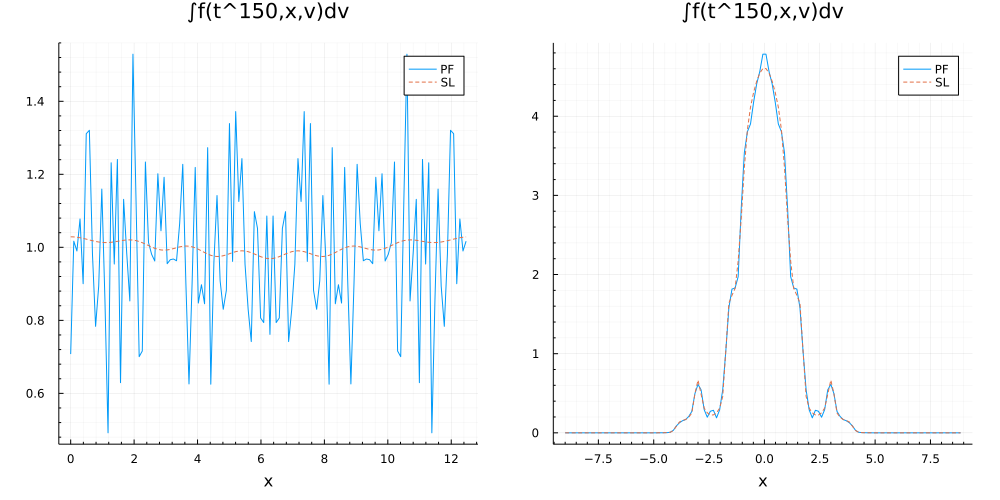

In [116]:
instant = nstep

valstoplot = ∫f(particles.x, particles.wei ./ vec(weights) .* meshv.step, meshx) # ∫fdv
p1 = plot(meshx.points, valstoplot,
            label="PF", minorgrid=true)
plot!(p1, meshx.points, vec(sum(real(gsl), dims=2)) .* meshv.step, label="SL", ls=:dash)
title!(p1, "∫f(t^$(instant),x,v)dv")
xlabel!(p1, "x")


valstoplot = ∫f(particles.v, particles.wei ./ vec(weights) .* meshx.step, meshv) # ∫fdv
p2 = plot(meshv.points, valstoplot,
            label="PF", minorgrid=true)
plot!(p2, meshv.points, vec(sum(real(gsl), dims=1)) .* meshx.step, label="SL", ls=:dash)
title!(p2, "∫f(t^$(instant),x,v)dv")
xlabel!(p2, "x")


plot(p1, p2, size=(1000, 500), margin=5Plots.mm)

In [66]:
valstoplot

Float64[]

## Coupe à $x$ fixé

In [ ]:
function coupe_x_fixe(posofslice, x, v, w; width=0.1)
    proj_to_slice = []
    for part = 1:nbparticles 
        ((x[part] < posofslice - width/2) || (x[part] > posofslice + width/2)) && continue
        push!(proj_to_slice, part)
    end
    permutation = sortperm(v[proj_to_slice])
    return v[proj_to_slice][permutation], w[proj_to_slice][permutation]
end

In [ ]:
instant = 1
width   = 0.5
sliceat = example.L/5
plot(coupe_x_fixe(sliceat, resPF.historyX[:, instant], resPF.historyV[:, instant], particles.wei; width=width)..., label="PF")
title!("f(t=t^$(instant-1), x ± "*@sprintf("%.4f", width)*", ⋅)")
xlabel!("v")

## Coupe à $v$ fixé

In [ ]:
function coupe_v_fixe(posofslice, x, v, w; width=0.1)
    proj_to_slice = []
    for part = 1:nbparticles 
        ((v[part] < posofslice - width/2) || (v[part] > posofslice + width/2)) && continue
        push!(proj_to_slice, part)
    end
    permutation = sortperm(x[proj_to_slice])
    return x[proj_to_slice][permutation], w[proj_to_slice][permutation]
end

In [ ]:
instant = 3
width   = 0.2
sliceat = 0.
plot(coupe_v_fixe(sliceat, particles.x, particles.v, particles.wei; width=width)..., label="PF")
plot!
title!("f(t=t^$(instant-1), x ± "*@sprintf("%.4f", width)*", ⋅)")
xlabel!("x")

# Repeated plots

In [ ]:
using Printf

# arr_examples = [example_landaudamping, example_stronglandaudamping, example_twostreaminstability, 
#                 example_bumpontail, example_stationarygaussian, example_nonhomogeneousstationarysolution]
arr_examples = [example_stationarygaussian]
arr_T = [10, 50, 101, 201, 250, 400, 500, NaN]

for example = arr_examples
    println(example.longname * " (" * example.shortname * ")")
    flush(stdout)

    nstep = 1000
    dt = 0.1

    nx = 127
    nv = 129

    meshx = OneDGrid(dev, nx, 0, example.L);
    meshv = OneDGrid(dev, nv, example.vmin, example.vmax);

    quadX = RectangleRule
    quadV = RectangleRule

    quadrulex = quadX(nx, 0, example.L);
    quadrulev = quadV(nv, example.vmin, example.vmax);

    nbparticles = nx*nv
    t = (1:nstep) .* dt
    
    gsl = zeros(Complex{Float64}, (nx,nv));
    @. gsl = example.f0.(meshx.points, meshv.points');
    resSL, animSL = solve_SL!(nstep, dt, gsl, meshx, meshv, example.kx; plotting=false);

    for T = arr_T 
        println("T=$(@sprintf("%03d", T))")
        flush(stdout)

        x0_init = copy(vec(repeat(quadrulex.points, 1, quadrulev.len)))
        v0_init = copy(vec(repeat(quadrulev.points', quadrulex.len, 1)))
        x0 = copy(vec(repeat(quadrulex.points, 1, quadrulev.len)))
        v0 = copy(vec(repeat(quadrulev.points', quadrulex.len, 1)))
        weights = quadrulex.weights .* quadrulev.weights'
        wei = vec(example.f0.(quadrulex.points, quadrulev.points') .* weights)
        # println("PF:")
        # flush(stdout)
        p = Particles(x0, v0, wei, nbparticles);
        resPF, animPF = solve_PIC!(nstep, dt, p, meshx, example, vec(weights) ; 
                                            plotting=false, kernel=kernel_poisson!, T=T);



        plot(legend=:bottomright, minorgrid=true, size=(600, 400))
        plot!(t .+ dt, log10.(resPF.Eelec), label=L"\log_{10}(E_{elec, PF}),\quad dt="*"$(dt)")
        plot!(t, log10.(resSL.Eelec), label=L"\log_{10}(E_{elec, SL}),\quad dt="*"$(dt)", ls=:dash, lw=1)
        title!(example.shortname * "\n($(quadX)($(nx)), $(quadV)($(nv)))", titlefontsize=8)
        xlabel!("t (T=$(T))")
        
        savefig(imgdir*"periodic_bdy_conditions/"*example.shortname*"_$(nx)_$(nv)_T$(@sprintf("%03d", T)).png")

        println("=====")
        flush(stdout)
    end
end

# Convergence interpolation

In [ ]:
# interpolation
x0_gridinit = copy(vec(repeat(meshx.points, 1, meshv.len)))
v0_gridinit = copy(vec(repeat(meshv.points', meshx.len, 1)))
(newf, tri) = triangulation_interpolation(p.wei ./ vec(weights), p.x, p.v, x0_gridinit, v0_gridinit, example;  
                                    returntriangulation=false)
println((nx, nv, sum((newf .- vec(real(gsl))).^2) * meshx.step * meshv.step))
plot(meshx.points, meshv.points, newf, st=:surface, camera=(0, 90), c=:jet1, right_margin=10Plots.mm)

## Evolution de la diff en norme L2 (entre SL raffiné et PF) en fonction du nombre de particules

(nx, nv, ||SL - PF||_2)

(8, 16, 1.9854954055349652)

(16, 32, 1.5415532148334858)

(32, 64, 0.8750895981106529)

(64, 128, 0.507113530637363)

(128, 256, 0.4465578959127579)

In [ ]:
plot(p.x, p.v, zcolor=p.wei ./ vec(weights), st=:scatter, c=:jet1, minorgrid=true)